In [51]:
import math

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print(torch.__version__)

2.0.0+cpu


In [52]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [53]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)


# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [54]:
print(training_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [55]:
# from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

output_mapping = {
                0: "T-shirt/Top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat", 
                5: "Sandal", 
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle Boot"
                }

Shape of X [N, C, H, W]: torch.Size([1000, 1, 28, 28])
Shape of y: torch.Size([1000]) torch.int64


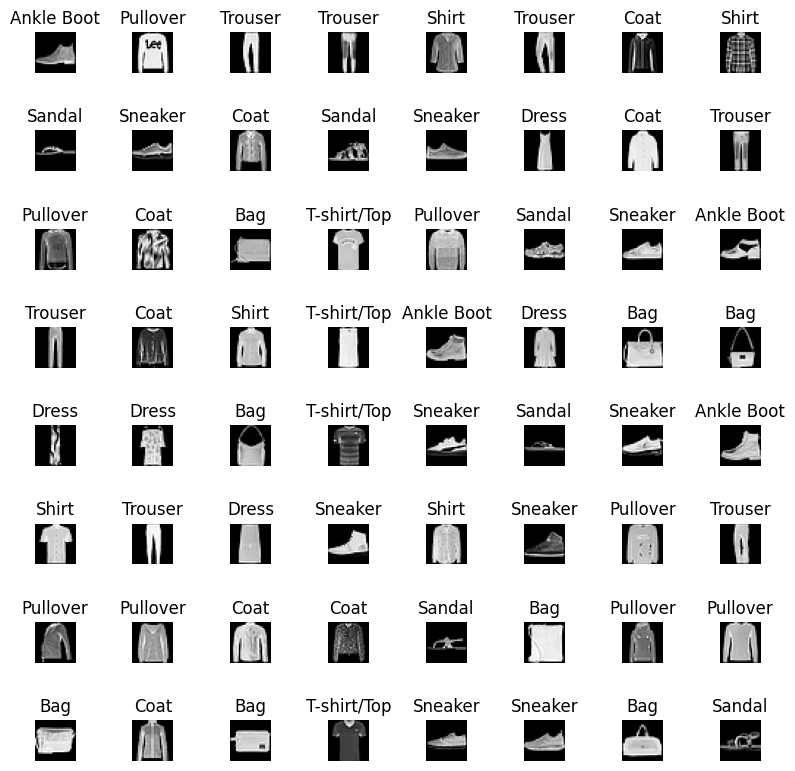

In [65]:
def plot_first_samples(dataloader, num_images=64):
    rows = 8
    columns = 16
    fig = plt.figure(figsize=(10, 10))
    for X, y in dataloader:
        for i, (image, label) in enumerate(zip(X, y)):
            if i >= num_images:
                break

            fig.add_subplot(rows, columns, 2*i+1)
            plt.axis('off')
            plt.title(output_mapping[label.item()])
            plt.imshow(image[0].detach().numpy(), cmap='gray')
        break

batch_size = 1000

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

plot_first_samples(test_dataloader)
plt.show()


In [66]:
def plot_first_samples(autoencoder, dataloader, max_num=64):
    rows = 8
    columns = 16
    fig = plt.figure(figsize=(10, 10))
    for X, y in dataloader:
        X_recon  = autoencoder(X.to(device)).to('cpu')
        for i, (image, image_recon, label) in enumerate(zip(X, X_recon, y)):
            if i >= max_num:
                break
            fig.add_subplot(rows, columns, 2*i+1)
            plt.axis('off')
            plt.title("O: " + str(label.item()))
            plt.imshow(image[0].detach().numpy(), cmap='gray')

            fig.add_subplot(rows, columns, 2*i+2)
            plt.axis('off')
            plt.title("R")
            plt.imshow(image_recon[0].detach().numpy(), cmap='gray')
        break

def plot_latent(autoencoder, data, num_batches=500):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            break
    plt.colorbar()#.ax.set_xticklabels(output_mapping.keys())

def plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gray')

In [62]:
# Variational Autoencoder

class Encoder(nn.Module):
    def __init__(self, input_shape : torch.Size, latent_size : int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape.numel(), 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, latent_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, latent_size : int, output_shape : torch.Size):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape.numel())
        )
        self.unflatten = nn.Unflatten(1, output_shape)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.unflatten(logits)
        return logits

class VariationalAutoencoder(nn.Module):
    def __init__(self, item_shape : torch.Size, latent_size : int):
        super().__init__()
        self.encoder = Encoder(item_shape, latent_size*2)
        self.decoder = Decoder(latent_size, item_shape)

        self.latent_size = latent_size
        self.N = torch.distributions.Normal(0, 1)

        self.kl = 0

        self.loss_fn = nn.MSELoss(reduction='sum')

    def compute_loss(self, X):
        X_recon = self.forward(X)
        return self.loss_fn(X_recon, X) + self.kl

    def forward(self, x):
        latent_item = self.encoder(x)
        mu, log_sigma = torch.split(latent_item, self.latent_size, 1)
        sigma = torch.exp(log_sigma)
        z = mu + sigma * self.N.sample(sigma.shape).to(device)
        self.kl = (sigma ** 2 + mu**2 - log_sigma - 1/2).sum() / mu.shape.numel()
        return self.decoder(z)
    

    def train_autoencoder(self, dataloader : DataLoader, optimizer : torch.optim.Optimizer):
        size = len(dataloader.dataset)
        self.train()
        for batch, (X, _) in enumerate(dataloader):
            X = X.to(device)

            # Compute prediction error
            loss = self.compute_loss(X)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % (len(dataloader) // 10) == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def test(self, dataloader : DataLoader):
        num_batches = len(dataloader)
        self.eval()
        test_loss = 0
        with torch.no_grad():
            for X, _ in dataloader:
                X = X.to(device)
                X_recon = self.forward(X)
                test_loss += (self.loss_fn(X_recon , X) + self.kl).item()
        test_loss /= num_batches
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [71]:
# Train Variational Autoencoder
size = torch.Size((1,28,28))
variational_autoencoder = VariationalAutoencoder(size, 2).to(device)

optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=1e-3)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    variational_autoencoder.train_autoencoder(train_dataloader, optimizer)
    variational_autoencoder.test(test_dataloader)
print("Done!")

Epoch 1
-------------------------------
loss: 171572.000000  [ 1000/60000]
loss: 68294.953125  [ 7000/60000]
loss: 60588.289062  [13000/60000]
loss: 54565.433594  [19000/60000]
loss: 51687.167969  [25000/60000]
loss: 50465.445312  [31000/60000]
loss: 49029.527344  [37000/60000]
loss: 43064.933594  [43000/60000]
loss: 38706.050781  [49000/60000]
loss: 36391.222656  [55000/60000]
Test Error: Avg loss: 34733.991797 

Epoch 2
-------------------------------
loss: 34887.175781  [ 1000/60000]
loss: 33448.652344  [ 7000/60000]
loss: 32740.201172  [13000/60000]
loss: 32200.896484  [19000/60000]
loss: 30971.525391  [25000/60000]
loss: 30692.443359  [31000/60000]
loss: 30250.927734  [37000/60000]
loss: 28157.046875  [43000/60000]
loss: 28300.886719  [49000/60000]
loss: 28464.660156  [55000/60000]
Test Error: Avg loss: 28806.252930 

Epoch 3
-------------------------------
loss: 28758.947266  [ 1000/60000]
loss: 28190.748047  [ 7000/60000]
loss: 28239.119141  [13000/60000]
loss: 28643.121094  [19

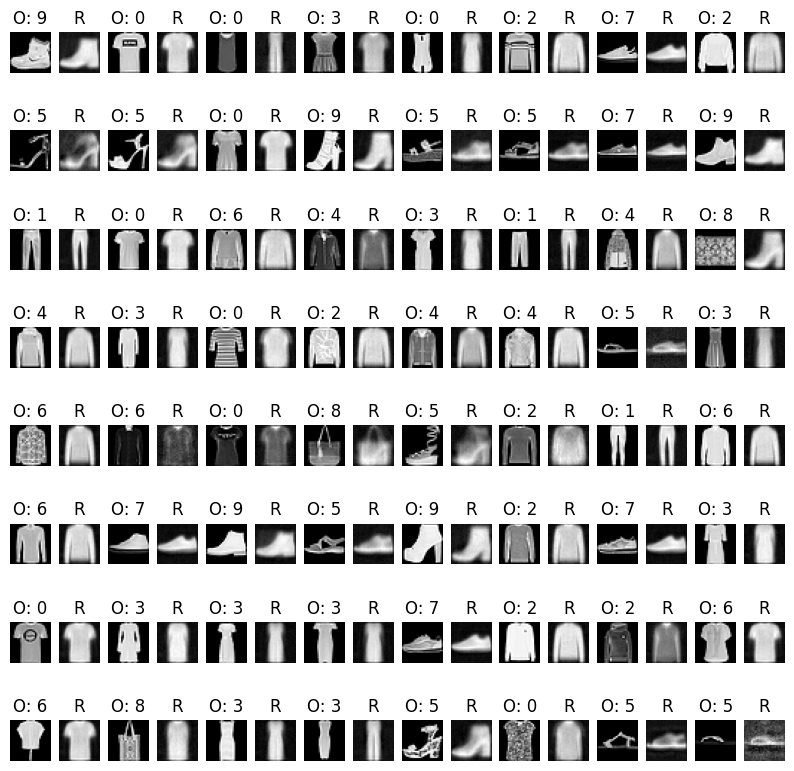

In [72]:
plot_first_samples(variational_autoencoder, train_dataloader)
plt.show()

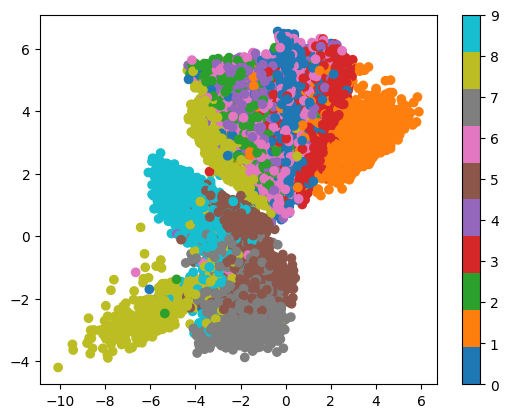

In [73]:
plot_latent(variational_autoencoder, test_dataloader)
plt.show()

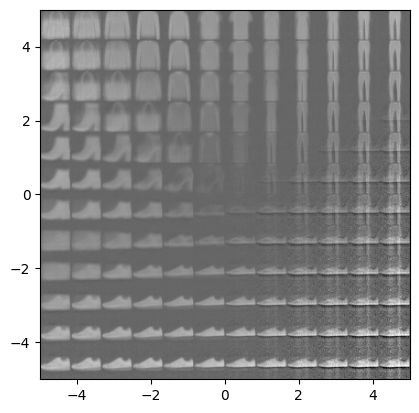

In [74]:
plot_reconstructed(variational_autoencoder)
plt.show()

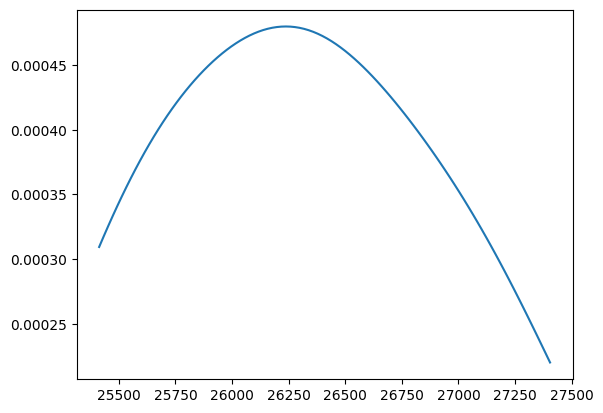

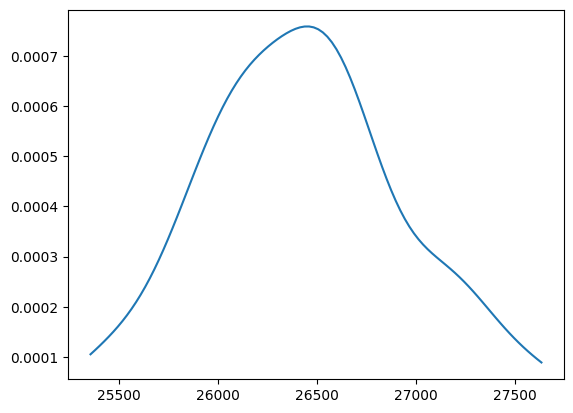

In [69]:
from scipy.stats import gaussian_kde

def plot_loss_kde(dataloader : DataLoader, model : VariationalAutoencoder):
    model.eval()
    loss_distribution = []
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            loss_distribution.append(model.compute_loss(X).item())
    loss_distribution = np.array(loss_distribution)
    data_space = np.linspace(min(loss_distribution), max(loss_distribution), 100 )
    kde = gaussian_kde(loss_distribution)
    plt.plot(data_space, kde(data_space))
    plt.show()

plot_loss_kde(test_dataloader, variational_autoencoder)
plot_loss_kde(train_dataloader, variational_autoencoder)
        

In [70]:
# calculate mean and std of latent

results = []
for x, _ in test_dataloader:
    z = variational_autoencoder.encoder(x.to(device))
    results.append(z.to('cpu').detach().numpy())

results = np.vstack(results)

print("Means:", np.mean(results, axis=0))
print("Stds:", np.std(results, axis=0))

Means: [-2.179933  -1.2829387 -8.953842  -9.339958 ]
Stds: [1.5320929 2.2649338 3.2282917 3.305861 ]
